# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Integrantes del grupo

Natalia Campiglia - 349251

Maria Jose Carbajal - 241319

# Imports

In [374]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary
import wandb

from sklearn.model_selection import train_test_split

import os
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter


from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_sweep_metrics_comparison,
    download_run,
    plot_class_distribution
)


# Constantes

In [ ]:
BATCH_SIZE = 256
SEED = 34
EPOCHS = 500

TRAIN_DATA_PATH = "data/mitbih_train.csv"
TEST_DATA_PATH = "data/mitbih_test.csv"

TARGET_NAMES = [
    "Normal",
    "Arritmia supraventricular",
    "Arritmia ventricular",
    "Latido fusionado",
    "Latido desconocido",
]

In [376]:
# Fijamos la semilla para que los resultados sean reproducibles
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [377]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando mps
Usando 0


# Carga de datos

In [378]:
import zipfile
from pathlib import Path

# Carpeta donde están los .zip
data_dir = Path("data")  # sin "/" inicial si estás en el mismo directorio del proyecto

# Asegurarnos de que el directorio existe
data_dir.mkdir(exist_ok=True)

# Lista de archivos zip a extraer
zip_files = ["mitbih_train.csv.zip", "mitbih_test.csv.zip"]

for zip_name in zip_files:
    zip_path = Path(zip_name)
    if zip_path.exists():
        # Verificar si el archivo CSV ya existe en data_dir
        csv_file = data_dir / zip_path.stem  # zip_path.stem es "mitbih_train.csv" para "mitbih_train.csv.zip"
        if not csv_file.exists():
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(data_dir)
                print(f"Extraído {zip_name} en {data_dir}")


In [379]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

# Análisis de datos

- Chequear NaNs o esten vacios , que sean negativos
- Graficar una señal del dataset para mostrar como se ve
- Ver clases balanceo etc
- Imprimir minimo, maximo , promedio etc...

In [380]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.423611,0.791667,1.000000,0.256944,0.000000,0.277778,0.465278,0.520833,0.472222,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.716814,0.539823,0.283186,0.129794,0.064897,0.076696,0.026549,0.032448,0.008850,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.874214,0.849057,0.480084,0.058700,0.090147,0.310273,0.387841,0.385744,0.389937,0.392034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.996086,0.694716,0.336595,0.238748,0.268102,0.191781,0.174168,0.164384,0.187867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [381]:
ninputs = df.shape[1] - 1
nclasses = df.iloc[:, -1].nunique()
print(f"Existen {nclasses} clases y {ninputs} características")

Existen 5 clases y 187 características


In [382]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [383]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Distribución de clases

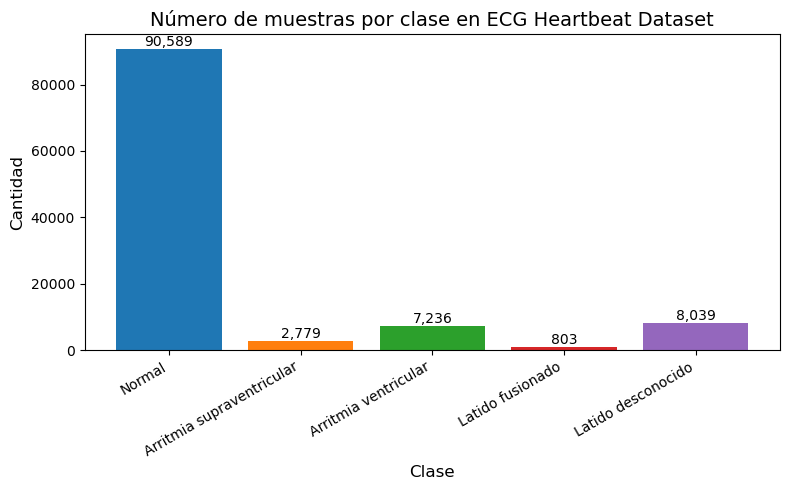

In [384]:
# Obtener conteos por clase (ordenados por índice)
class_count = df.iloc[:, -1].value_counts().sort_index()

plot_class_distribution(
    x_labels=TARGET_NAMES,
    y_values=class_count.values,
    title="Número de muestras por clase en ECG Heartbeat Dataset"
)

Las clases estan desbalanceadas.....

COMENTAR EN QUE NOS AFECTA Y DE QUE FORMAS SE PODRIA RESOLVER ... 


Se observa una distribución fuertemente desbalanceada, donde la clase Normal representa más del 80% del total de los latidos. Las demás clases están subrepresentadas, siendo menores al 10 % del tamaño de la clase normal.
En particular, la clase Arritmia supraventricular que es la que mas nos importa detectar, tiene apenas un 3% de las muestras que posee la clase normal.

Este desbalance afecta directamente al modelo, ya que aunque el modelo se comporte bien teniando una accurancy alta no nos aseguraria que es capaz de detectar clases distintas a la normal, sin estar detectando correctamente las arritmias, que son justamente las más importantes.

Por eso, es fundamental tener en cuenta este desbalance durante el entrenamiento.
Algunas estrategias para mitigarlo son:
* Ponderación en la función de pérdida (class weights) para penalizar más los errores en clases raras
* Muestreo balanceado (WeightedRandomSampler) que aumente la frecuencia de las clases menos representadas durante el entrenamiento.
* Aumentación de datos específica para las clases minoritarias, generando nuevas muestras a partir de transformaciones leves de las señales originales.

# Preprocesamiento básico

En esta sección definimos preprocesamiento básico.

Más adelante hacemos pruebas con y sin balanceo de clases para ver como afecta al resultado final.


En la parte del presocesamiento es cuando se pueden empezar a realizar procesos de regularizacion, algunos de los presos de regularizacion mensionados en clase fuero:

* penalizando weights
* Regularizaci´on Ridge como a priori Gaussiana (augmentation)
* Batch normalization
* Clipping del gradiente

# normalizar datos,  "z score" T.Normalize(mean=T_MEAN, std=T_STD),
# Ver que hacer con los NaN
# pasar a tensor X_train y_train / test 
# T.ToDtype(torch.float32, scale=True),

### Convertimos datos no numericos a cero

In [385]:
has_nans = df_train.isna().any().any()
has_nans_test = df_test.isna().any().any()
# --- Convertir todo a numérico (forzando errores a NaN) ---
print(f"NaN en train: {has_nans}, NaN en test: {has_nans_test}")

# --- Convertir todo a numérico (forzando errores a NaN) ---
df_train = df_train.apply(pd.to_numeric, errors='coerce')
df_test  = df_test.apply(pd.to_numeric, errors='coerce')

df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

NaN en train: False, NaN en test: False


In [386]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]   # Extraemos las etiquetas


X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]


print("X_train Shapes:", X_train.shape)
print("y_train Shapes:", y_train.shape)
print("X_test Shapes:", X_test.shape)
print("y_test Shapes:", y_test.shape)

X_train Shapes: (87554, 187)
y_train Shapes: (87554,)
X_test Shapes: (21892, 187)
y_test Shapes: (21892,)


In [387]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (70043, 187) Val: (17511, 187)


### Normalizacion

hacemos uso de z-score normalization

In [388]:
def zscore_normalization(x, eps = 1e-8):
    # mean = X.mean(axis=1, keepdims=True)
    # std  = X.std(axis=1, keepdims=True)
    # return (X - mean) / (std + eps)

    mean = x.mean()
    std = x.std()
    return (x - mean) / (std + eps)

### Agmentation 

In [389]:
def add_gaussian_noise(x, sigma_range=(0.005, 0.02), p=0.7):
    if np.random.rand() < p:
        sigma = np.random.uniform(*sigma_range)
        x = x + np.random.normal(0.0, sigma, size=x.shape).astype(x.dtype)
    return x

### Transform function: 
Funcion creada para aplicar las funciones anteriores segun flags

In [390]:
def train_transform_np(X, use_zscore=False, use_augmentation=False) -> np.ndarray:
    x = X.copy()
    if use_zscore:
        x = zscore_normalization(x)
    if use_augmentation:
        x = add_gaussian_noise(x)
    return x

def eval_transform_np(X, use_zscore=False):
    if use_zscore:
        X = zscore_normalization(X)
    return X

# Dataset y DataLoader

Nuestro dataset **`ECGDataset`** toma las **señales de electrocardiograma (ECG)** ya preprocesadas y sus etiquetas correspondientes, y las prepara para ser utilizadas por PyTorch.  
Cada muestra representa un **latido cardíaco** de 187 puntos, con una etiqueta asociada que indica el tipo de latido (normal o alguna arritmia).

El dataset convierte los datos en tensores, aplica transformaciones opcionales como **normalización** o **aumentación de datos**, y ajusta su forma según el tipo de modelo que vayamos a usar:

- Si `for_cnn=True`, devuelve los tensores en formato `[1, 187]`, listos para una **CNN1D**, que aprende patrones locales en la forma de onda.  
- Si `for_cnn=False`, devuelve los tensores en formato `[187, 1]`, adecuados para **RNN/LSTM/GRU**, que procesan secuencias temporalmente.

Luego, el **DataLoader** se encarga de cargar los datos en **lotes (batches)** durante el entrenamiento, de manera eficiente y balanceada.  
Podemos usar un **WeightedRandomSampler** para que las clases menos representadas (como las arritmias) aparezcan con más frecuencia en los batches, evitando que el modelo se sesgue hacia la clase “Normal”.

[link](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)



## Dataser

In [ ]:
class ECGDataset(Dataset):
    def __init__(self, df_features, df_target, transform=None, target_transform=None, for_cnn=False):
        # Acepta DataFrame/Series o ndarray
        self.x_df = np.asarray(df_features, dtype=np.float32)
        self.y_df = np.asarray(df_target, dtype=np.int64)
        # self.x_df = df_features.values
        # self.y_df = df_target.values
        self.transform = transform
        self.target_transform = target_transform     
        self.for_cnn = for_cnn

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        # TODO: check si pasar a tensor antes de transformar es correcto
        x = self.x_df[idx]
        y = self.y_df[idx]
        
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
            

        if self.for_cnn:
            x = torch.tensor(x, dtype=torch.float32)
        else: 
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # [187, 1]
        y = torch.tensor(y, dtype=torch.long)  # la cross-entropy loss necesita que el target sea long      

        # if idx < 3:  # solo las primeras veces
        #     print(f"[DEBUG] idx={idx}, x.shape={x.shape}, y={y}")
        return x, y


## Dataloader

In [ ]:
# TODO: PASAR A UTILS ??
# Wrapper para aplicar transformaciones

# =========================
# Sampler y utilidades
# =========================
def get_counts(y):
    y = np.asarray(y)
    counts = Counter(y)
    total = len(y)
    return counts, total


def make_weighted_sampler(y, n_classes=5):
    counts, total = get_counts(y)
    class_weight = {c: total / (n_classes * counts.get(c, 1)) for c in range(n_classes)}
    sample_weights = np.array([class_weight[int(lbl)] for lbl in y], dtype=np.float32)
    weights_tensor = torch.from_numpy(sample_weights)
    return WeightedRandomSampler(weights=weights_tensor, num_samples=len(weights_tensor), replacement=True)



def get_dataloaders(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    train_transf=None, val_transf=None,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
    use_sampler = True,
    for_cnn = False, 
    # pin_memory: bool = True,
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - X_train: features del dataset
    - y_train: labels del dataset
    - train_transf: transformaciones para el dataset de entrenamiento
    - val_transf: transformaciones para el dataset de val
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    train_dataset = ECGDataset(X_train, y_train, train_transf, for_cnn=for_cnn)
    val_dataset = ECGDataset(X_val, y_val, val_transf, for_cnn=for_cnn)
    test_dataset = ECGDataset(X_test, y_test, val_transf, for_cnn=for_cnn)

    # si usamos use_sampler entonces el batch se balancea por muestreo
    sampler = make_weighted_sampler(y_train, n_classes=5) if use_sampler else None
    shuffle = shuffle=not use_sampler

    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, val_loader, test_loader

## Testing dataloaders returns shapes

In [393]:

train_loader, val_loader, test_loader = get_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, use_sampler=False, for_cnn=True
)

print(f"Train loader: {train_loader}")
print(f"Val loader: {val_loader}")
print(f"Test loader: {test_loader}")

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x333b3e050>
Val loader: <torch.utils.data.dataloader.DataLoader object at 0x333b3e350>
Test loader: <torch.utils.data.dataloader.DataLoader object at 0x333b3df50>
torch.Size([256, 187]) torch.Size([256])


# Opcion con augmentation sin class weights
random oversampling / undersampling

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=weights_tensor,
    num_samples=len(weights_tensor),  # mismo tamaño que el dataset
    replacement=True  # importante, permite repetir ejemplos minoritarios
)


# Ver transfer learning entre nuestras pruebas

# Models

## 1. SIMPLE RNN

In [408]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, dropout=0.3):
        super(SimpleRNN, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_dim, hidden_dim * 2)
        self.out = nn.Linear(hidden_dim * 2, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        _, hidden = self.rnn(x)              # out: [batch, seq_len, hidden_dim]
        hidden = hidden[-1]                    # último hidden state: [batch, hidden_dim]
        x = self.relu(self.fc(hidden))        # [batch, hidden_dim*2]
        x = self.drop(x)
        # no necesito usar softmax porque CrossEntropyLoss ya lo aplica
        x = self.out(x)                        # [batch, num_classes]
        return x


### 1.1. Testing RNN

In [409]:
rnn_model = SimpleRNN(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

In [402]:
train_loader, val_loader, test_loader = get_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, use_sampler=False
)

In [405]:
xb, yb = next(iter(train_loader))
xb, yb = xb.to(DEVICE), yb.to(DEVICE)

logits = rnn_model(xb)
print("Logits shape:", logits.shape)  # [batch_size, num_classes]
loss = criterion(logits, yb)
print("Loss:", loss.item())

Logits shape: torch.Size([256, 5])
Loss: 1.6862796545028687


## 2. GRU

[GRU](https://d2l.ai/chapter_recurrent-modern/gru.html) en una RNN con dos gates extras (reset y update) para controlar cómo fluye la información entre pasos temporales. 

Se agega la flag bidirectional, que en caso de estar activa PyTorch crea dos GRUs internas, una que procesa la secuencia hacia adelante (normal) y otra que procesa la secuencia hacia atrás, esto tiene como ventaja que cada punto de la secuencia tiene información tanto del pasado como del futuro.

In [410]:

class SimpleGRU(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, dropout=0.3, bidirectional=False):
        super(SimpleGRU, self).__init__()
        self.bidirectional = bidirectional
        self.n_layers = n_layers
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        # Si es bidireccional, duplicamos el tamaño del hidden state
        factor = 2 if bidirectional else 1
        self.fc= nn.Linear(hidden_dim * factor, hidden_dim * 2)
        self.our = nn.Linear(hidden_dim * 2, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        _, hidden = self.gru(x)       # hidden: [n_layers * num_directions, batch, hidden_dim]
        hidden = hidden[-1] if not self.bidirectional else torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.relu(self.fc1(hidden))
        x = self.drop(x)
        x = self.fc2(x)
        return x  # [batch, num_classes]


# Training

In [ ]:

def compute_class_weights(y, n_classes=5):
    counts, total = get_counts(y)
    weights = np.array([total / (n_classes * counts.get(c, 1)) for c in range(n_classes)], dtype=np.float32)
    weights = weights / weights.mean()  # opcional: normalizar
    return torch.tensor(weights, dtype=torch.float32)

In [ ]:
def run_rnn_model(use_zscore=False, use_augmentation=False, use_sampler=False, use_class_weights=False, early_stopping=False, model='rnn'):

    train_transf = lambda x: train_transform_np(x, use_zscore=use_zscore, use_augmentation=use_augmentation)
    val_transf   = lambda x: eval_transform_np(x,  use_zscore=use_zscore)

    train_loader, val_loader, test_loader = get_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        train_transf=train_transf,
        val_transf=val_transf,
        use_sampler=use_sampler  # True => balancea batches por muestreo
    )
    
    if model == 'rnn':
        model = SimpleRNN(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5).to(DEVICE)
    elif model == 'gru':
        model = SimpleGRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=True).to(DEVICE)
    else:
        raise ValueError(f"Modelo {model} no soportado")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # si usamos use_class_weights entonces se balancea por class weights
    if use_class_weights:
        class_weights = compute_class_weights(y_train, n_classes=5).to(DEVICE)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()


    # Chequeo rápido
    xb, yb = next(iter(train_loader))
    print("Batch:", xb.shape, yb.shape)  # esperado: [B,187,1]  [B]

    epoch_train_errors, epoch_val_errors = train(
        model,
        optimizer,
        criterion, 
        train_loader,
        val_loader,
        DEVICE,
        do_early_stopping=early_stopping,
        patience=20,
        epochs=EPOCHS,
        log_every=20,
    )

    model_classification_report(model, test_loader, DEVICE, nclasses)

    return epoch_train_errors, epoch_val_errors
    

## Training RNN

Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020 | Train Loss: 0.66044 | Val Loss: 0.65829
Detener entrenamiento en la época 22, la mejor pérdida fue 0.64565
Accuracy: 0.8277

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91     14494
           1       0.00      0.00      0.00       445
           2       0.00      0.00      0.00      1158
           3       0.00      0.00      0.00       128
           4       0.00      0.00      0.00      1286

    accuracy                           0.83     17511
   macro avg       0.17      0.20      0.18     17511
weighted avg       0.69      0.83      0.75     17511



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

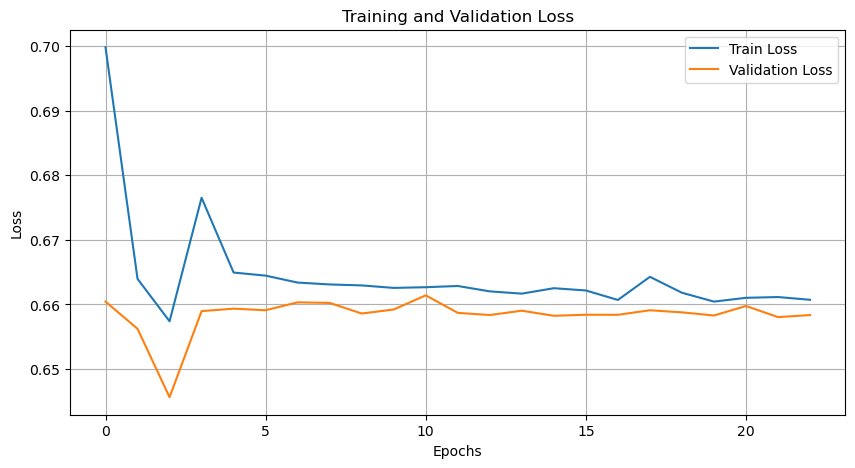

In [413]:
epoch_train_errors, epoch_val_errors = run_rnn_model()
plot_training(epoch_train_errors, epoch_val_errors)

### Probamos modelo actualizando los pesos segun 

Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020 | Train Loss: 1.60548 | Val Loss: 1.61078
Detener entrenamiento en la época 27, la mejor pérdida fue 1.24668
Accuracy: 0.8211

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     14494
           1       0.00      0.00      0.00       445
           2       0.14      0.02      0.04      1158
           3       0.00      0.00      0.00       128
           4       0.00      0.00      0.00      1286

    accuracy                           0.82     17511
   macro avg       0.19      0.20      0.19     17511
weighted avg       0.69      0.82      0.75     17511



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

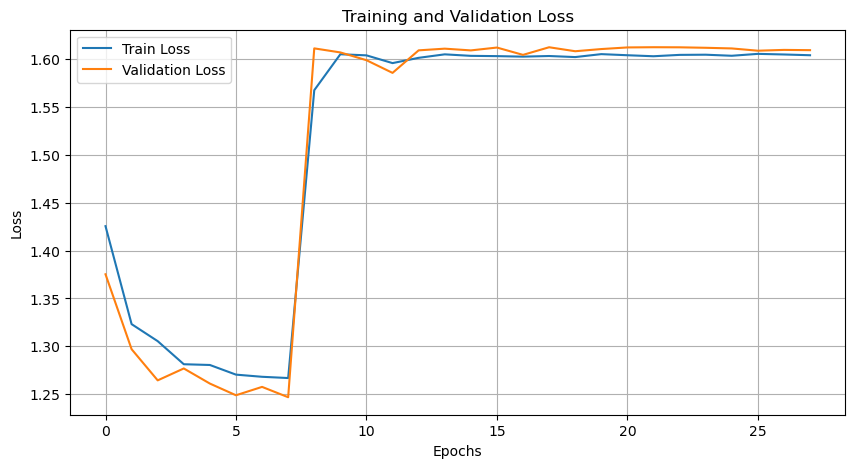

In [ ]:
epoch_train_errors, epoch_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, use_sampler=False, use_class_weights=True)
print("--------------------------------")
plot_training(epoch_train_errors, epoch_val_errors)

Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 010 | Train Loss: 1.09151 | Val Loss: 1.39737
Epoch: 020 | Train Loss: 0.97383 | Val Loss: 1.25579
Epoch: 030 | Train Loss: 1.23272 | Val Loss: 1.53493
Epoch: 040 | Train Loss: 1.21575 | Val Loss: 1.42044
Epoch: 050 | Train Loss: 1.21945 | Val Loss: 1.40985
Epoch: 060 | Train Loss: 1.22478 | Val Loss: 1.40393
Epoch: 070 | Train Loss: 1.28697 | Val Loss: 1.44766
Epoch: 080 | Train Loss: 1.22937 | Val Loss: 1.39825
Epoch: 090 | Train Loss: 1.26947 | Val Loss: 1.48343
Epoch: 100 | Train Loss: 0.94824 | Val Loss: 1.08203
Epoch: 110 | Train Loss: 0.80840 | Val Loss: 1.14382
Epoch: 120 | Train Loss: 1.10142 | Val Loss: 1.05190
Epoch: 130 | Train Loss: 0.75381 | Val Loss: 0.90701
Epoch: 140 | Train Loss: 0.71393 | Val Loss: 0.89042
Epoch: 150 | Train Loss: 0.64332 | Val Loss: 0.84708
Epoch: 160 | Train Loss: 1.02728 | Val Loss: 1.51761
Epoch: 170 | Train Loss: 1.31001 | Val Loss: 1.41608
Epoch: 180 | Train Loss: 1.32300 | Val Loss: 1.4

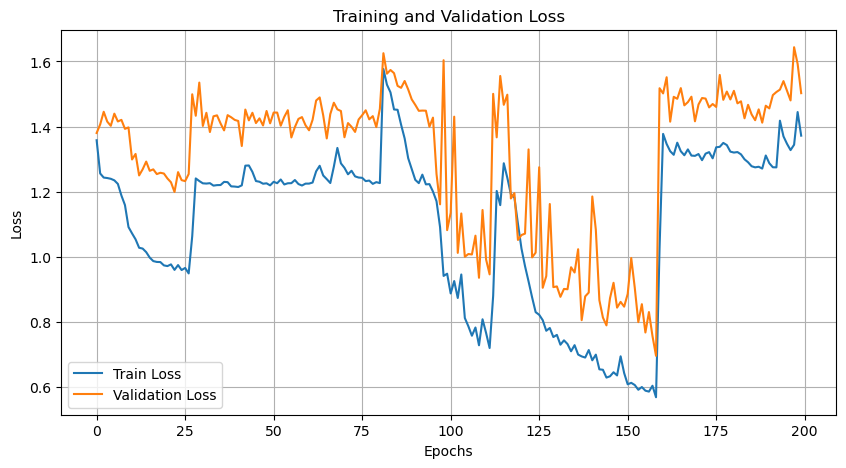

In [ ]:
epoch_train_errors, epoch_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, use_sampler=True, use_class_weights=False, early_stopping=False)
plot_training(epoch_train_errors, epoch_val_errors)

## Training GRU



Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020 | Train Loss: 1.15692 | Val Loss: 1.47540
Epoch: 040 | Train Loss: 1.15673 | Val Loss: 1.46222
Epoch: 060 | Train Loss: 1.09402 | Val Loss: 1.35662
Epoch: 080 | Train Loss: 0.98363 | Val Loss: 1.26044
Epoch: 100 | Train Loss: 0.96670 | Val Loss: 1.22167
Epoch: 120 | Train Loss: 1.23612 | Val Loss: 1.41052
Epoch: 140 | Train Loss: 1.23146 | Val Loss: 1.38729
Epoch: 160 | Train Loss: 1.28401 | Val Loss: 1.44929
Epoch: 180 | Train Loss: 1.16218 | Val Loss: 1.37986
Epoch: 200 | Train Loss: 0.67473 | Val Loss: 0.99954
Accuracy: 0.5376

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.48      0.64     14494
           1       0.10      0.73      0.18       445
           2       0.32      0.79      0.45      1158
           3       0.04      0.90      0.07       128
           4       0.84      0.90      0.87      1286

    accuracy                           0.54     

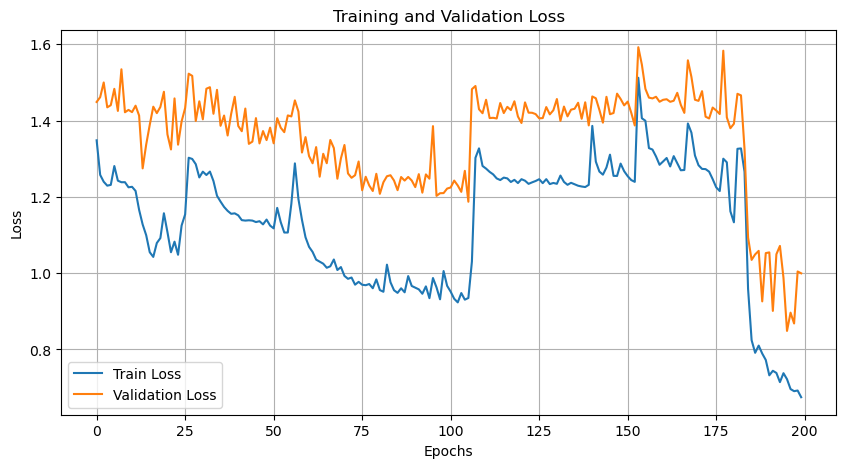

In [418]:
gru_1_train_errors, qru_1_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, use_sampler=True, use_class_weights=False, early_stopping=False)
plot_training(gru_1_train_errors, qru_1_val_errors)

# Modelo 3: LSTM